In [29]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:

train_data_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Train'
valid_data_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Valid'

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    labels = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        labels.append(name)

    return labels

# Function to load and preprocess dataset
def load_data(dataset_path):
    images = []
    labels = []

    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(dataset_path, filename)
            xml_path = os.path.join(dataset_path, filename.replace('.jpg', '.xml'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            label = parse_xml(xml_path)

            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_data(train_data_path)
valid_images, valid_labels = load_data(valid_data_path)

# Convert labels to one-hot encoding
unique_classes = list(set([label for sublist in train_labels for label in sublist]))
class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

def convert_labels_to_one_hot(label):
    one_hot = np.zeros(len(unique_classes))
    for l in label:
        one_hot[class_to_index[l]] = 1
    return one_hot

train_label_map = np.array([convert_labels_to_one_hot(label) for label in train_labels])
valid_label_map = np.array([convert_labels_to_one_hot(label) for label in valid_labels])

num_classes = len(unique_classes)
print(num_classes)
print("Unique Labels:", unique_classes)





<ipython-input-21-662bd7bd843a>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


37
Unique Labels: ['air', 'apel', 'bakso', 'ikan', 'gudeg', 'cumi', 'Nasi', 'donat', 'bubur', 'anggur', 'mie', 'ayam', 'kentang', 'fu_yung_hai', 'Roti', 'kebab', 'cakwe', 'pempek', 'jeruk', 'serabi', 'soto', 'Tempe', 'es_krim', 'ayam betutu', 'kacang', 'crepes', 'rawon', 'kopi', 'bakwan', 'batagor', 'sate', 'Tahu', 'burger', 'durian', 'nasi kuning', 'capcay', 'kerupuk']


In [ ]:
# Create and configure the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Assuming 39 classes
])

# Compile the model (same as before)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
batch_size = 32
train_generator = datagen.flow(train_images, train_label_map, batch_size=batch_size)
valid_generator = datagen.flow(valid_images, valid_label_map, batch_size=batch_size)


model.fit(train_generator, epochs=50, validation_data=valid_generator)

# Save the model
model.save('image_classification_model.h5')

Epoch 1/50
22/22 [==============================] - 19s 645ms/step - loss: 3.5432 - accuracy: 0.1560 - val_loss: 2.9051 - val_accuracy: 0.2614
Epoch 2/50
 2/22 [=>............................] - ETA: 7s - loss: 2.4846 - accuracy: 0.3438

In [9]:
from google.colab import files

1/1 [==============================] - 1s 1s/step


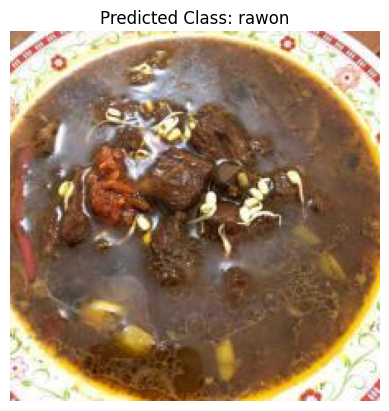

In [27]:
model_path = '/content/drive/MyDrive/Dataset_3/model/image_classificationV2.h5'
model = load_model(model_path)
test_image_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Valid/Rawon-36_jpg.rf.4701504f1eba9f7f7d3ccca35ef93a47.jpg'
img = image.load_img(test_image_path, target_size=(224, 224)  )
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_label = unique_classes[predicted_class]

# Display the original image and the predicted class
img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()


In [33]:

# Evaluate the model on the validation set
valid_predictions = model.predict(valid_images)

# Convert predictions to one-hot encoding
valid_predictions_one_hot = np.argmax(valid_predictions, axis=1)
valid_labels_one_hot = np.argmax(valid_label_map, axis=1)

# Generate the classification report
report = classification_report(valid_labels_one_hot, valid_predictions_one_hot, target_names=unique_classes)

# Print and/or use the 'report' variable as needed
print(report)

10/10 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

         air       1.00      0.62      0.76        13
        apel       0.86      0.75      0.80         8
       bakso       0.17      0.17      0.17         6
        ikan       0.00      0.00      0.00         8
       gudeg       0.12      0.56      0.20         9
        cumi       0.00      0.00      0.00        19
        Nasi       0.67      0.67      0.67        15
       donat       0.00      0.00      0.00         6
       bubur       0.00      0.00      0.00        25
      anggur       0.67      0.60      0.63        10
         mie       0.00      0.00      0.00         3
        ayam       0.11      0.67      0.19         9
     kentang       0.00      0.00      0.00         8
 fu_yung_hai       0.09      0.67      0.15         6
        Roti       0.64      0.93      0.76        15
       kebab       0.00      0.00      0.00         6
       cakwe       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
